In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding, get_scheduler
from datasets import load_dataset, concatenate_datasets

from accelerate import Accelerator

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW

import numpy as np

import os
import sys
sys.path.append(os.getcwd()+"/../..")

from src import paths

import tqdm

import evaluate 

from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay


In [2]:
# Load data
data_files = {"train": "ms-diag_clean_train.csv", "validation": "ms-diag_clean_val.csv", "test": "ms-diag_clean_test.csv"}
df = load_dataset(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag'), data_files = data_files)

# Number of labels
num_labels = len(set(df['train']['labels']))

# Label to id
label2id = {label: i for i, label in enumerate(set(df['train']['labels']))}
id2label = {i: label for i, label in enumerate(set(df['train']['labels']))}

In [4]:
id2label

{0: 'relapsing_remitting_multiple_sclerosis',
 1: 'secondary_progressive_multiple_sclerosis',
 2: 'primary_progressive_multiple_sclerosis'}

In [5]:
# Subsample stratisfied by label
df['train'] = concatenate_datasets([df['train'].filter(lambda example: example['labels'] == 'primary_progressive_multiple_sclerosis'), 
                                     df['train'].filter(lambda example: example['labels'] == 'secondary_progressive_multiple_sclerosis'),
                                     df['train'].filter(lambda example: example['labels'] == "relapsing_remitting_multiple_sclerosis").select(range(0,20))])

Filter:   0%|          | 0/143 [00:00<?, ? examples/s]

Filter:   0%|          | 0/143 [00:00<?, ? examples/s]

Filter:   0%|          | 0/143 [00:00<?, ? examples/s]

In [ ]:
# # Run this cell if you want to download and fine-tune the model
# from huggingface_hub import notebook_login

# # Login to Hugging Face Hub as model is gated
# notebook_login()

# # Checkpoint
# checkpoint = "GerMedBERT/medbert-512"

# # Load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# # Save tokenizer
# tokenizer.save_pretrained(paths.MODEL_PATH/'medbert')

# # Load model for embedding
# model = AutoModel.from_pretrained(checkpoint)

# # Save model
# model.save_pretrained(paths.MODEL_PATH/'medbert')

In [6]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(paths.MODEL_PATH/'medbert')

# Load model
model = AutoModelForSequenceClassification.from_pretrained(paths.MODEL_PATH/'medbert', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /cluster/dataset/midatams/inf-extr/resources/models/medbert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def prepare_data(data):
    
    # Label
    data['labels'] = [label2id[label] for label in data['labels']]

    # Tokenize
    data = tokenizer(data['text'], padding=True, truncation=True, return_tensors='pt')

    return data

# Tokenize dataset
dataset = df.map(prepare_data, batched=True, remove_columns=['rid', 'text', 'date'], batch_size=512)

Map:   0%|          | 0/39 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

In [8]:
# Training arguments
EPOCHS = 15
BATCH_SIZE = 16
TRAIN_STEPS = EPOCHS * len(dataset['train']) // BATCH_SIZE

# Collator
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')

# Dataloader
train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Accelerator
accelerator = Accelerator(mixed_precision='fp16')

# Optimizer and scheduler
optim = AdamW(model.parameters(), lr=1e-6)
lr_scheduler = get_scheduler(
    "linear",
    optim,
    num_warmup_steps=0,
    num_training_steps=TRAIN_STEPS
)

#f1_metric = evaluate.load("f1")

# Class weights
power = 1
class_weights = [1/np.log(len(dataset['train'].filter(lambda example: example['labels'] == label))) for label in set(dataset['train']['labels'])]
class_weights = [weight**power for weight in class_weights]
class_weights = torch.tensor(class_weights, dtype=torch.float)


loss_fun = torch.nn.CrossEntropyLoss(weight=class_weights)

# Prepare with accelerator
model, optim, train_loader, val_loader, test_loader, loss_fun = accelerator.prepare(
    model, optim, train_loader, val_loader, test_loader, loss_fun
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Filter:   0%|          | 0/39 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39 [00:00<?, ? examples/s]

Filter:   0%|          | 0/39 [00:00<?, ? examples/s]

In [12]:
class_weights

tensor([0.3338, 0.4343, 0.4551])

In [9]:
# Training
torch.manual_seed(42)
progress_bar = tqdm.tqdm(range(TRAIN_STEPS))

for epoch in range(EPOCHS):
    model.train()
    for batch in train_loader:
        optim.zero_grad()
        outputs = model(**batch)
        loss = loss_fun(outputs.logits, batch['labels'])
        accelerator.backward(loss)
        optim.step()
        lr_scheduler.step()
        progress_bar.update(1)

    model.eval()
    with torch.no_grad():
        preds = []
        labels = []
        val_loss = 0
        acc = 0
        for batch in val_loader:
            outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            
            val_loss += loss_fun(outputs.logits, batch['labels'])
            acc += (predictions == batch['labels']).sum().item()
            
            preds.extend(predictions.tolist())
            labels.extend(batch['labels'].tolist())

    f1 = f1_score(labels, preds, average='weighted')
    if epoch == 0:
            min_val_loss = val_loss
    elif epoch >= 5 & (val_loss < min_val_loss):
        min_val_loss = val_loss
        model.save_pretrained(paths.MODEL_PATH/'ms_diag_medbert')

    print(f"Epoch {epoch+1}: F1 score: {f1} Loss: {val_loss/len(val_loader)} Accuracy: {acc/len(dataset['validation'])}")

  8%|▊         | 3/36 [00:01<00:14,  2.28it/s]

Epoch 1: F1 score: 0.532608695652174 Loss: 1.032335877418518 Accuracy: 0.4375


 17%|█▋        | 6/36 [00:02<00:08,  3.74it/s]

Epoch 2: F1 score: 0.7844827586206897 Loss: 1.0190677642822266 Accuracy: 0.8125


 25%|██▌       | 9/36 [00:04<00:11,  2.45it/s]

Epoch 3: F1 score: 0.7844827586206897 Loss: 1.0080866813659668 Accuracy: 0.8125


 33%|███▎      | 12/36 [00:06<00:10,  2.24it/s]

Epoch 4: F1 score: 0.7844827586206897 Loss: 1.0004127025604248 Accuracy: 0.8125


 42%|████▏     | 15/36 [00:08<00:09,  2.11it/s]

Epoch 5: F1 score: 0.8166666666666667 Loss: 0.9919957518577576 Accuracy: 0.875


 50%|█████     | 18/36 [00:09<00:08,  2.14it/s]

Epoch 6: F1 score: 0.8166666666666667 Loss: 0.9865912795066833 Accuracy: 0.875


 58%|█████▊    | 21/36 [00:11<00:07,  2.13it/s]

Epoch 7: F1 score: 0.8166666666666667 Loss: 0.9827457070350647 Accuracy: 0.875


 67%|██████▋   | 24/36 [00:13<00:05,  2.14it/s]

Epoch 8: F1 score: 0.8166666666666667 Loss: 0.9795671701431274 Accuracy: 0.875


 75%|███████▌  | 27/36 [00:15<00:04,  2.13it/s]

Epoch 9: F1 score: 0.8166666666666667 Loss: 0.9772969484329224 Accuracy: 0.875


 83%|████████▎ | 30/36 [00:17<00:02,  2.13it/s]

Epoch 10: F1 score: 0.8166666666666667 Loss: 0.9764156937599182 Accuracy: 0.875


 92%|█████████▏| 33/36 [00:19<00:01,  2.12it/s]

Epoch 11: F1 score: 0.8166666666666667 Loss: 0.9756913781166077 Accuracy: 0.875


100%|██████████| 36/36 [00:21<00:00,  2.13it/s]

Epoch 12: F1 score: 0.8166666666666667 Loss: 0.9752244353294373 Accuracy: 0.875


39it [00:22,  2.13it/s]                        

Epoch 13: F1 score: 0.8166666666666667 Loss: 0.9752244353294373 Accuracy: 0.875


42it [00:24,  2.13it/s]

Epoch 14: F1 score: 0.8166666666666667 Loss: 0.9752244353294373 Accuracy: 0.875


45it [00:26,  2.13it/s]

Epoch 15: F1 score: 0.8166666666666667 Loss: 0.9752244353294373 Accuracy: 0.875


In [10]:
torch.cuda.empty_cache()

# Predictions
predictions = []
labels = []
#f1_test = evaluate.load("f1")
for batch in tqdm.tqdm(test_loader):
    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        #f1_test.add_batch(predictions=preds, references=batch['labels'])
        predictions.extend(preds.tolist())
        labels.extend(batch['labels'].tolist())

#f1_score = f1_test.compute(average='weighted')
#print("F1", f1_score)


100%|██████████| 3/3 [00:00<00:00, 12.12it/s]


F1 Score: 0.8166666666666667
Precision: 0.765625
Recall: 0.875


/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


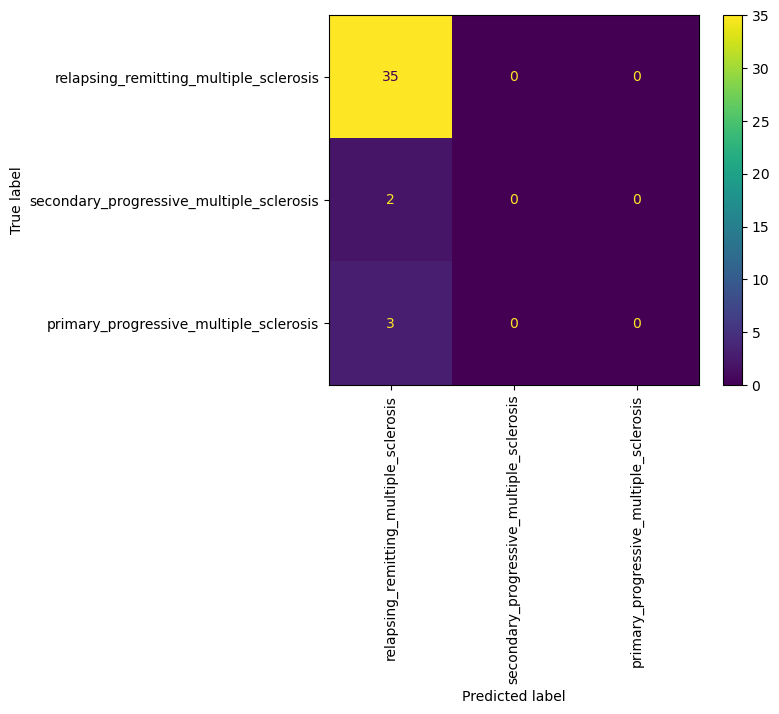

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# f1 score, precision, recall
print(f"F1 Score: {f1_score(labels, predictions, average='weighted')}")
print(f"Precision: {precision_score(labels, predictions, average='weighted')}")
print(f"Recall: {recall_score(labels, predictions, average='weighted')}")
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(labels, predictions, display_labels=list(id2label.values()), xticks_rotation='vertical')

In [ ]:
import pandas as pd
df_test = pd.read_csv(os.path.join(paths.DATA_PATH_PREPROCESSED,'ms-diag/ms-diag_clean_test.csv'))
df_test[df_test['labels']==id2label[1]]['text']